In [49]:
import numpy as np
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt


def alpha_IR(f1,f2):
    y = 1.64*(f1-f2)-2.82
    return y


def mJy_to_mag(F, F0):
    m = -2.5*np.log10(F*0.001/F0)
    return m


def e_mJy_to_mag(e_F, F):
    m = (2.5/np.log(10))*(e_F/F)
    return m

# c2d


In [2]:
# C2D with Quality flags for each column
c2d = Table.read('../c2d.fit').to_pandas()

FileNotFoundError: [Errno 2] No such file or directory: 'c2d.fit'

In [3]:
# Change the byte strings to regular strings and remove excess space
for colname in ['OType','q_FJ', 'q_FH', 'q_FKs', 'q_FIR1', 'q_FIR2', 'q_FIR3', 'q_FIR4', 'q_FMP1', 'q_FMP2']:
    c2d[colname] = c2d[colname].str.decode('utf-8')
    c2d[colname] = c2d[colname].str.rstrip()
# Rename object types in terms of classifications, and remove any ambiguous classifications
c2d.replace({'OType': r'^YSOc'}, {'OType': 0},regex=True,inplace=True)
c2d.replace({'OType': r'^star'}, {'OType': 2},regex=True,inplace=True)
c2d.replace({'OType': r'^Galc'}, {'OType': 1},regex=True,inplace=True)
c2d.rename(columns={"OType":"Target"},inplace=True)
c2d = c2d[pd.to_numeric(c2d['Target'], errors='coerce').notnull()]


print(f"YSO shape: {c2d[c2d['Target']==0].shape}")
print(f"EG shape: {c2d[c2d['Target']==1].shape}")
print(f"Star shape: {c2d[c2d['Target']==2].shape}")

# Remove unnecessary columns
c2d.drop(['Name', 'Cat', 'Region','recno'], axis=1,inplace=True)

c2d

YSO shape: (4038, 35)
EG shape: (6660, 35)
Star shape: (881015, 35)


,RAJ2000,DEJ2000,alpha,Target,FJ,e_FJ,q_FJ,FH,e_FH,q_FH,...,q_FIR3,FIR4,e_FIR4,q_FIR4,FMP1,e_FMP1,q_FMP1,FMP2,e_FMP2,q_FMP2
2,277.212616,0.859071,-2.32,2,0.410,0.054,B,1.0,0.073,B,...,B,0.086,0.052,U,-0.259,0.302,U,0.0,0.0,N
4,277.212616,0.665340,-2.28,2,0.699,0.056,A,2.0,0.084,A,...,A,0.307,0.044,B,0.011,0.242,U,0.0,0.0,U
9,277.126923,0.464996,-2.74,2,0.000,0.000,N,0.0,0.000,N,...,C,0.046,0.027,U,0.070,0.258,U,0.0,0.0,U
16,277.120972,0.430608,-2.16,2,0.461,0.000,U,1.0,0.077,B,...,A,0.188,0.044,C,-0.045,0.297,U,0.0,0.0,U
19,277.126404,0.792648,-2.48,2,2.290,0.078,A,4.0,0.140,A,...,A,0.642,0.054,A,-0.093,0.242,U,0.0,0.0,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634891,67.516670,18.230413,-0.92,0,567.000,12.000,A,670.0,11.100,A,...,A,262.000,13.000,A,1210.000,112.000,A,0.0,0.0,U
6634892,75.777412,25.388849,-1.00,0,173.000,3.500,A,240.0,6.400,A,...,A,126.000,6.540,A,193.000,17.800,A,0.0,0.0,U
6634893,252.190079,-14.276626,-0.97,0,519.000,11.500,A,957.0,33.500,A,...,A,1010.000,56.400,A,1270.000,118.000,A,0.0,0.0,U
6634894,67.714104,24.706188,-1.21,0,254.000,4.910,A,341.0,9.100,A,...,A,115.000,5.820,A,118.000,10.900,A,0.0,0.0,U


In [4]:
# Find smallest reliable flux for each band and replace any flux tagged 'U' (for upper limit) with 1/100th of this to represent thermal noise.
columns = [idx for idx in c2d.columns.values if idx[0].lower() == 'F'.lower()]
for c in columns:
    min_f = min(c2d[c2d['q_'+c]=='A'][c])
    c2d.loc[c2d['q_'+c]=='N',c] = min_f/100
    c2d.loc[c2d['q_'+c]=='U',c] = min_f/100


In [5]:


# Change fluxes to Vega magnitudes
c2d.dropna()
c2d_fluxes = c2d[columns].values.astype(float).transpose() # Fluxes
e_columns = [idx for idx in c2d.columns.values if idx[0].lower() == 'e'.lower()]
c2d_fluxes_errs = c2d[e_columns].values.astype(float).transpose() #Errors
# Convert flux to magnitudes
for i, F_0 in enumerate([1594, 1024, 666.7, 277.500, 179.500, 116.600, 63.100, 7.140]):
    c2d[columns[i]] = mJy_to_mag(c2d_fluxes[i],F_0) # Convert fluxes in a column to mags
    c2d[e_columns[i]] = e_mJy_to_mag(c2d_fluxes_errs[i],c2d_fluxes[i]) # Convert errors in a column to mag


print(f"YSO shape: {c2d[c2d['Target']==0].shape}")
print(f"EG shape: {c2d[c2d['Target']==1].shape}")
print(f"Star shape: {c2d[c2d['Target']==2].shape}")
c2d.columns = ['RAJ2000', 'DEJ2000', 'alpha', 'Target', 'mag_J', 'e_mag_J', 'q_mag_J', 'mag_H',
       'e_mag_H', 'q_mag_H', 'mag_Ks', 'e_mag_Ks', 'q_mag_Ks', 'mag_IR1', 'e_mag_IR1', 'q_mag_IR1',
       'mag_IR2', 'e_mag_IR2', 'q_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'q_mag_IR3', 'mag_IR4',
       'e_mag_IR4', 'q_mag_IR4', 'mag_MP1', 'e_mag_MP1', 'q_mag_MP1', 'mag_MP2', 'e_mag_MP2',
       'q_mag_MP2']
c2d.dropna(subset=['mag_IR1','e_mag_IR1','mag_IR2','e_mag_IR2','mag_IR3','e_mag_IR3','mag_IR4','e_mag_IR4'],inplace=True)

print(f"YSO shape: {c2d[c2d['Target']==0].shape}")
print(f"EG shape: {c2d[c2d['Target']==1].shape}")
print(f"Star shape: {c2d[c2d['Target']==2].shape}")
# Change column names to reflect these are magnitudes now


c2d

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_37760/3115989305.py:7: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(F*0.001/F0)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_37760/3115989305.py:12: RuntimeWarning: divide by zero encountered in true_divide
  m = (2.5/np.log(10))*(e_F/F)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_37760/3115989305.py:12: RuntimeWarning: invalid value encountered in true_divide
  m = (2.5/np.log(10))*(e_F/F)


YSO shape: (4038, 31)
EG shape: (6660, 31)
Star shape: (881015, 31)
YSO shape: (4038, 31)
EG shape: (6660, 31)
Star shape: (880985, 31)


,RAJ2000,DEJ2000,alpha,Target,mag_J,e_mag_J,q_mag_J,mag_H,e_mag_H,q_mag_H,...,q_mag_IR3,mag_IR4,e_mag_IR4,q_mag_IR4,mag_MP1,e_mag_MP1,q_mag_MP1,mag_MP2,e_mag_MP2,q_mag_MP2
2,277.212616,0.859071,-2.32,2,16.474261,0.142999,B,15.025750,0.079259,B,...,B,19.311206,47.443935,U,15.428883,68.168884,U,0.291,0.0,N
4,277.212616,0.665340,-2.28,2,15.895028,0.086983,A,14.273175,0.045601,A,...,A,13.282227,0.155610,B,15.428883,54.625397,U,0.291,0.0,U
9,277.126923,0.464996,-2.74,2,21.652273,0.000000,N,20.025750,0.000000,N,...,C,19.311206,24.634351,U,15.428883,58.236994,U,0.291,0.0,U
16,277.120972,0.430608,-2.16,2,21.652273,0.000000,U,15.025750,0.083602,B,...,A,13.814679,0.254108,C,15.428883,67.040260,U,0.291,0.0,U
19,277.126404,0.792648,-2.48,2,14.606632,0.036981,A,13.520600,0.038001,A,...,A,12.481236,0.091324,A,15.428883,54.625397,U,0.291,0.0,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634891,67.516670,18.230413,-0.92,0,8.622263,0.022979,A,7.960563,0.017988,A,...,A,5.954320,0.053872,A,1.927282,0.100498,A,0.291,0.0,U
6634892,75.777412,25.388849,-1.00,0,9.911106,0.021966,A,9.075222,0.028953,A,...,A,6.749147,0.056355,A,3.920352,0.100135,A,0.291,0.0,U
6634893,252.190079,-14.276626,-0.97,0,8.718302,0.024058,A,7.573470,0.038006,A,...,A,4.489270,0.060629,A,1.874736,0.100879,A,0.291,0.0,U
6634894,67.714104,24.706188,-1.21,0,9.494137,0.020988,A,8.693864,0.028974,A,...,A,6.848329,0.054948,A,4.454541,0.100293,A,0.291,0.0,U


In [9]:
c2d.replace([np.inf, -np.inf], np.nan, inplace=True)
c2d.dropna(inplace=True)

print(f"YSO shape: {c2d[c2d['Target']==0].shape}")
print(f"EG shape: {c2d[c2d['Target']==1].shape}")
print(f"Star shape: {c2d[c2d['Target']==2].shape}")

YSO shape: (3959, 31)
EG shape: (6426, 31)
Star shape: (775866, 31)


In [10]:
c2d.to_csv('c2d_w_quality.csv')

In [8]:
np.all(np.isfinite(c2d[['mag_IR1','e_mag_IR1','mag_IR2','e_mag_IR2','mag_IR3','e_mag_IR3','mag_IR4','e_mag_IR4','mag_MP1','e_mag_MP1']].values))

True

# NGC 3324


In [20]:
n33_df = pd.read_csv("VelaCarC_l286.csv",delim_whitespace=True,comment="#",header=0,index_col=1)

n33_DF = n33_df[['ra', 'dec','mag_J','dJ_m','mag_H','dH_m','mag_Ks','dKs_m','mag3_6', 'd3_6m', 'mag4_5', 'd4_5m', 'mag5_8','d5_8m', 'mag8_0', 'd8_0m']]
# n33_DF = n33_df[['ra', 'dec','f_J','df_J','f_H','df_H','f_Ks','df_Ks','f3_6', 'df3_6', 'f4_5', 'df4_5', 'f5_8','df5_8', 'f8_0', 'df8_0']]


In [21]:
# Rename columns
n33_DF.columns = ['RAJ2000', 'DEJ2000', 'mag_J', 'e_mag_J', 'mag_H', 'e_mag_H', 'mag_Ks',\
              'e_mag_Ks', 'mag_IR1', 'e_mag_IR1', 'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3',\
                     'mag_IR4', 'e_mag_IR4']

# Adjust upper limits
n33_DF.replace(to_replace=99.999,value=np.nan,inplace=True)

columns = [idx for idx in n33_DF.columns.values if idx[0] == 'm']
for i, c in enumerate(columns):
    min_m = np.nanmax(n33_DF[c])+5 # Adding 5 is equivalent to dividing the flux by 100
    n33_DF[c].fillna(min_m,inplace=True)
    n33_DF['e_'+c].fillna(np.mean(n33_DF['e_'+c]),inplace=True)

# Add spectral index
n33_DF['alpha'] = alpha_IR(n33_DF['mag_IR2'],n33_DF['mag_IR4'])

n33_DF.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_7216/2876169398.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n33_DF.replace(to_replace=99.999,value=np.nan,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_7216/2876169398.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n33_DF[c].fillna(min_m,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_7216/2876169398.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,RAJ2000,DEJ2000,mag_J,e_mag_J,mag_H,e_mag_H,mag_Ks,e_mag_Ks,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha
G286.0000-01.6076,157.553803,-59.753506,14.943,0.049000,14.287,0.058,14.000,0.068,13.718,0.109,19.896,0.124897,18.524,0.144951,18.350,0.119339,-0.28456
G286.0000-01.4378,157.726576,-59.607751,9.592,0.036000,9.276,0.042,9.192,0.031,9.224,0.037,9.228,0.046000,9.163,0.044000,9.185,0.030000,-2.74948
G286.0000-00.2122,158.929997,-58.549566,16.158,0.119000,14.774,0.077,14.117,0.067,13.685,0.084,13.462,0.109000,18.524,0.144951,18.350,0.119339,-10.83632
G286.0000-00.8792,158.284282,-59.126860,15.620,0.089000,14.849,0.093,14.773,0.130,14.220,0.097,14.089,0.163000,18.524,0.144951,18.350,0.119339,-9.80804
G286.0000-00.0972,159.039269,-58.449703,22.188,0.050843,15.259,0.122,14.368,0.097,13.771,0.112,13.427,0.149000,18.524,0.144951,18.350,0.119339,-10.89372


In [22]:
n33_DF.to_csv("NGC_3324.csv")

# NGC 2264 + Orion

In [96]:
N22O = pd.read_csv("../../Archive/Phase_1__Three_Class_Classification/Data_and_Results/catalog.csv")[['Unnamed: 0', '3.6', 'd_3.6', '4.5', 'd_4.5', '5.8', 'd_5.8', '8',
       'd_8', '24', 'd_24', 'target', 'pred']]
print(np.unique(N22O[['target']].values))
N22O['alpha'] = alpha_IR(N22O[['4.5']].values,N22O[['8']].values)
N22O.columns = ['ID', 'mag_IR1', 'e_mag_IR1',
       'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4',
       'e_mag_IR4', 'mag_MP1', 'e_mag_MP1','Target','Pred_CM','alpha']
N22O.head()

[0 1 2 3 4 5 6]


,ID,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,mag_MP1,e_mag_MP1,Target,Pred_CM,alpha
0,0,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,-99.0,-99.0,6,2,-2.5904
1,1,11.62,0.003,11.60,0.004,11.55,0.016,11.56,0.035,-99.0,-99.0,6,2,-2.7544
2,2,13.38,0.007,13.28,0.011,13.27,0.050,13.78,0.155,-99.0,-99.0,6,2,-3.6400
3,3,12.52,0.005,12.52,0.006,12.40,0.030,12.41,0.053,-99.0,-99.0,6,2,-2.6396
4,4,13.71,0.009,13.66,0.013,13.60,0.069,13.67,0.148,-99.0,-99.0,6,2,-2.8364


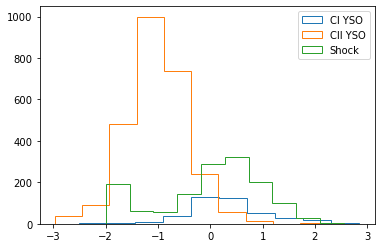

In [97]:
# plt.hist(N22['alpha'].values[np.where(N22[['Target']]==0)[0]],histtype='step',density=False,label='YSO')
# plt.hist(N22['alpha'].values[np.where(N22[['Target']]==1)[0]],histtype='step',density=False,label='EG')
# # plt.hist(N22['alpha'].values[np.where(N22[['Target']]==2)[0]],density=True,histtype='step',label='Star)
# plt.hist(N22['alpha'].values[np.where(N22[['Target']]==3)[0]],histtype='step',density=False,label='Other')
d = False
plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==0)[0]],histtype='step',density=d,label='CI YSO')
plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==1)[0]],histtype='step',density=d,label='CII YSO')
# plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==2)[0]],density=d,histtype='step',label='AGN')
plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==3)[0]],histtype='step',density=d,label='Shock')
# plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==4)[0]],histtype='step',density=d,label='PAH')
# plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==5)[0]],histtype='step',density=d,label='Gal')
# plt.hist(N22O['alpha'].values[np.where(N22O[['Target']]==6)[0]],histtype='step',density=d,label='Star')

plt.legend()

In [101]:
# Fill in undetected sources with thermal noise
F_0 = [277.500, 179.500, 116.600, 63.100, 7.140]
N22O.replace(-99.,np.nan,inplace=True)
columns = [idx for idx in N22O.columns.values if idx[0] == 'm']
for i, c in enumerate(columns):
    min_m = np.nanmax(N22O[c])+5 # Adding 5 is equivalent to dividing the flux by 100
    N22O[c].fillna(min_m,inplace=True)
    N22O['e_'+c].fillna(np.mean(N22O['e_'+c]),inplace=True)


# Relabel targets
N22O['OG_Target'] = N22O['Target']
targets = np.zeros(len(N22O[['Target']].values))
targets[np.where(N22O[['OG_Target']].values==0)[0]] = 0
targets[np.where(N22O[['OG_Target']].values==1)[0]] = 0
targets[np.where(N22O[['OG_Target']].values==2)[0]] = 1
targets[np.where(N22O[['OG_Target']].values==3)[0]] = 1
targets[np.where(N22O[['OG_Target']].values==4)[0]] = 1
targets[np.where(N22O[['OG_Target']].values==5)[0]] = 1
targets[np.where(N22O[['OG_Target']].values==6)[0]] = 2
N22O['Target'] = targets



,ID,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,mag_MP1,e_mag_MP1,Target,Pred_CM,alpha,OG_Target
0,0,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,17.34,0.089753,2.0,2,-2.5904,6
1,1,11.62,0.003,11.60,0.004,11.55,0.016,11.56,0.035,17.34,0.089753,2.0,2,-2.7544,6
2,2,13.38,0.007,13.28,0.011,13.27,0.050,13.78,0.155,17.34,0.089753,2.0,2,-3.6400,6
3,3,12.52,0.005,12.52,0.006,12.40,0.030,12.41,0.053,17.34,0.089753,2.0,2,-2.6396,6
4,4,13.71,0.009,13.66,0.013,13.60,0.069,13.67,0.148,17.34,0.089753,2.0,2,-2.8364,6


In [110]:

Orion = N22O[N22O.ID>7790]
Orion.to_csv('Orion.csv')
print(Orion.shape)
Orion.head()

(19112, 15)


,ID,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,mag_MP1,e_mag_MP1,Target,Pred_CM,alpha,OG_Target
7791,7791,11.513,0.004,11.491,0.005,11.434,0.017,11.373,0.030,17.34,0.089753,2.0,2,-2.62648,6
7792,7792,13.672,0.011,13.653,0.017,13.647,0.108,13.444,0.154,17.34,0.089753,2.0,2,-2.47724,6
7793,7793,11.998,0.005,11.985,0.006,11.898,0.024,12.010,0.048,17.34,0.089753,2.0,2,-2.86100,6
7794,7794,13.042,0.008,13.030,0.012,12.945,0.055,12.928,0.098,17.34,0.089753,2.0,2,-2.65272,6
7795,7795,13.357,0.009,13.327,0.011,13.252,0.062,13.249,0.108,17.34,0.089753,2.0,2,-2.69208,6


In [103]:
N22O.shape

(26903, 15)

In [102]:
N22O.to_csv("CM_NGC2264_Orion.csv")

# SPICY

In [41]:
spicy = pd.read_csv("../../Archive/SPICY_YSO_SubClasses.csv",comment='#')[['mag_IR1', 'e_mag_IR1', 'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4', 'alpha', 'class    ']]
spicy.head()

,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha,class
0,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,-1.51695368300395E+00,ClassII
1,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,-6.43206342197073E-01,ClassII
2,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,-2.14090416881411E-03,FS
3,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,3.37295842881326E-01,ClassI
4,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,-2.78597489454348E-01,FS


In [42]:

columns = [idx for idx in spicy.columns.values if idx[0] == 'm']
for i, c in enumerate(columns):
    min_m = np.nanmax(spicy[c])+5 # Adding 5 is equivalent to dividing the flux by 100
    spicy[c].fillna(min_m,inplace=True)
    spicy['e_'+c].fillna(np.mean(spicy['e_'+c]),inplace=True)

spicy['alpha'] = alpha_IR(spicy['mag_IR2'],spicy['mag_IR4'])
targets = np.zeros(len(spicy.values[:,0]))
targets[np.where(spicy[['class    ']].values=='uncertain')[0]] = 2
spicy['Target'] = targets 


In [43]:
yso_targets = np.zeros(len(spicy.values[:,0]))
print(np.unique(spicy[['class    ']].values))
yso_targets[np.where(spicy[['class    ']].values=='ClassI   ')[0]] = 0
yso_targets[np.where(spicy[['class    ']].values=='       ')[0]] = 1
yso_targets[np.where(spicy[['class    ']].values=='ClassII  ')[0]] = 2
yso_targets[np.where(spicy[['class    ']].values=='ClassIII ')[0]] = 3
yso_targets[np.where(spicy[['class    ']].values=='uncertain')[0]] = 5  

spicy['yso_targets'] = yso_targets



['ClassI   ' 'ClassII  ' 'ClassIII ' 'FS       ' 'uncertain']


In [44]:
spicy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117446 entries, 0 to 117445
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mag_IR1      117446 non-null  float64
 1   e_mag_IR1    117446 non-null  float64
 2   mag_IR2      117446 non-null  float64
 3   e_mag_IR2    117446 non-null  float64
 4   mag_IR3      117446 non-null  float64
 5   e_mag_IR3    117446 non-null  float64
 6   mag_IR4      117446 non-null  float64
 7   e_mag_IR4    117446 non-null  float64
 8   alpha        117446 non-null  float64
 9   class        117446 non-null  object 
 10  Target       117446 non-null  float64
 11  yso_targets  117446 non-null  float64
dtypes: float64(11), object(1)
memory usage: 10.8+ MB


In [45]:
spicy.to_csv("SPICY_w_quality.csv")